<a href="https://colab.research.google.com/github/jh-4166640/Machine-Learning-Lecture/blob/main/robostar_stock_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [74]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np


robostar = yf.download('090360.KQ',start= '2021-01-01')
date =  robostar.index.values
robostar = robostar.to_numpy()
date_short = np.array([str(d)[:10] for d in date])

/tmp/ipython-input-2759589626.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  robostar = yf.download('090360.KQ',start= '2021-01-01')
[*********************100%***********************]  1 of 1 completed


In [75]:
close_idx = 0
high_idx = 1
low_idx = 2
open_idx = 3
volume_idx = 4
ma_idx = 5

moveDay = 30 # 초단기 이동평균선
moveAverage = np.zeros((robostar.shape[0],1))


for day in range(moveDay-1, robostar.shape[0]):
  sum = 0
  for idx in range(0,moveDay):
    sum += robostar[day-idx,close_idx]
  mA = sum / moveDay
  moveAverage[day,] = mA


rate_data = np.diff(robostar[:, :4], axis=0) / robostar[:-1, :4] * 100

data = np.concatenate((robostar, moveAverage), axis=1)   #이동 평균선 추가
data = np.concatenate((data[1:,:], rate_data), axis=1)   #변화율 추가
data = data[moveDay-2:,:]
date=date[moveDay-2:]


In [76]:
from sklearn.preprocessing import MinMaxScaler
# 데이터 정규화
scaler = MinMaxScaler()
norm_data = scaler.fit_transform(data)


In [77]:
# train test 분할
train_ratio = 0.7
lookback = 5 # 예측을 할 때 얼마나 넣고 할거냐

train_idx = int(norm_data.shape[0] * train_ratio)
train_data = norm_data[:train_idx]
test_data = norm_data[train_idx:]

x_train = []
t_train = []

for idx in range(train_data.shape[0] - lookback):
  x_train.append(train_data[idx:idx+lookback])
  t_train.append(train_data[idx+lookback,0:volume_idx+1].T)
x_train = np.array(x_train)
t_train = np.array(t_train)


In [78]:
import keras


# model = keras.models.Sequential() #LSTM
# model.add(keras.layers.LSTM(units=50,activation='tanh',return_sequences=True,input_shape=(lookback,10)))
# model.add(keras.layers.LSTM(units=25))
# model.add(keras.layers.Dense(units=5))
# model.compile(optimizer='adam', loss='mean_squared_error')


model = keras.Sequential([ # CNN-LSTM
    keras.layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(lookback, 10)),
    keras.layers.MaxPooling1D(pool_size=2),
    keras.layers.LSTM(100, activation='tanh'),
    keras.layers.Dense(5)
])
model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [79]:
epoch = 300

checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,        # validation_loss 기준 최적 모델만 저장
    monitor="val_loss",
    mode="min"
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,       # 10 Epoch 동안 개선 없으면 종료
    restore_best_weights=True  # 종료 시 최적 가중치 복원
)

history = model.fit(x_train[:,:],t_train,epochs=epoch,batch_size=32,callbacks=[checkpoint_cb, earlystop_cb])

Epoch 1/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/model_checkpoint.py:302: UserWarning: Can save best model only with val_loss available.
  if self._should_save_model(epoch, batch, logs, filepath):


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0081
Epoch 2/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0012
Epoch 3/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4318e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5538e-04
Epoch 4/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 5/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013
Epoch 6/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2537e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8321e-04
Epoch 7/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010     

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.4426e-04
Epoch 8/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0010     

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.5642e-04
Epoch 9/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2714e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7052e-04
Epoch 10/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.2443e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2427e-04
Epoch 11/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2665e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.4406e-04
Epoch 12/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0469e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8091e-04
Epoch 13/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4226e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6444e-04
Epoch 14/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.7803e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.0211e-04
Epoch 15/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.8320e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7452e-04
Epoch 16/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7846e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5185e-04
Epoch 17/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3917e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9336e-04
Epoch 18/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0688e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.7623e-04
Epoch 19/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0692e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5762e-04
Epoch 20/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8937e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9396e-04
Epoch 21/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9628e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.9228e-04
Epoch 22/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4739e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0136e-04
Epoch 23/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5184e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.1772e-04
Epoch 24/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.8751e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7634e-04
Epoch 25/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.1970e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.4914e-04
Epoch 26/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8797e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7910e-04
Epoch 27/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8395e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5831e-04
Epoch 28/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6183e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.8429e-04
Epoch 29/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0716e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.2094e-04
Epoch 30/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0095e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5009e-04
Epoch 31/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6135e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1733e-04
Epoch 32/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6618e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1783e-04
Epoch 33/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9086e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9867e-04
Epoch 34/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3715e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.3201e-04
Epoch 35/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.6560e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.8772e-04
Epoch 36/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.8943e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9283e-04
Epoch 37/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4131e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.8987e-04
Epoch 38/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1535e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1123e-04
Epoch 39/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.3109e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9989e-04
Epoch 40/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0565e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5377e-04
Epoch 41/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2433e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3748e-04
Epoch 42/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6272e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7105e-04
Epoch 43/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5889e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7605e-04
Epoch 44/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0442e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5474e-04
Epoch 45/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.5037e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.0927e-04
Epoch 46/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6701e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.9664e-04
Epoch 47/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5197e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5701e-04
Epoch 48/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0959e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1529e-04
Epoch 49/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7715e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4568e-04
Epoch 50/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.0959e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9127e-04
Epoch 51/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1066e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8191e-04
Epoch 52/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6007e-04
Epoch 53/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4411e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0219e-04
Epoch 54/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4230e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0922e-04
Epoch 55/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9442e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6782e-04
Epoch 56/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4073e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0119e-04
Epoch 57/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1224e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5205e-04
Epoch 58/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7567e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5240e-04
Epoch 59/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0162e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3408e-04
Epoch 60/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1961e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2290e-04
Epoch 61/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0485e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0764e-04
Epoch 62/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4291e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4363e-04
Epoch 63/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4223e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4342e-04
Epoch 64/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9011e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6247e-04
Epoch 65/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6082e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6549e-04
Epoch 66/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6038e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.3869e-04
Epoch 67/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0891e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1073e-04
Epoch 68/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2220e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8167e-04
Epoch 69/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4277e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.7288e-04
Epoch 70/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7415e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0558e-04
Epoch 71/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6497e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7094e-04
Epoch 72/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8138e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5575e-04
Epoch 73/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0275e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7174e-04
Epoch 74/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5961e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.6195e-04
Epoch 75/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5850e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4733e-04
Epoch 76/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4641e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4741e-04
Epoch 77/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1020e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0720e-04
Epoch 78/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4110e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2567e-04
Epoch 79/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.4401e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5524e-04
Epoch 80/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5262e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8995e-04
Epoch 81/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4595e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3539e-04
Epoch 82/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5829e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7766e-04
Epoch 83/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3250e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0536e-04
Epoch 84/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7012e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7299e-04
Epoch 85/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3824e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1589e-04
Epoch 86/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6210e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6543e-04
Epoch 87/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1109e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3063e-04
Epoch 88/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.6241e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1581e-04
Epoch 89/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9568e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6788e-04
Epoch 90/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5086e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3998e-04
Epoch 91/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4487e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8088e-04
Epoch 92/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3016e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8741e-04
Epoch 93/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1859e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0266e-04
Epoch 94/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1303e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3980e-04
Epoch 95/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2869e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3950e-04
Epoch 96/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6410e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3106e-04
Epoch 97/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0551e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4936e-04
Epoch 98/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6758e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7539e-04
Epoch 99/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4304e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2780e-04
Epoch 100/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5037e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2976e-04
Epoch 101/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9341e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.6254e-04
Epoch 102/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1386e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8423e-04
Epoch 103/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9602e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4746e-04
Epoch 104/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.9655e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.9366e-04
Epoch 105/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3296e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3180e-04
Epoch 106/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9931e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1230e-04
Epoch 107/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2024e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5536e-04
Epoch 108/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0290e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6322e-04
Epoch 109/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5493e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6063e-04
Epoch 110/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2747e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7660e-04
Epoch 111/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5608e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5814e-04
Epoch 112/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1960e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4083e-04
Epoch 113/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8265e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0855e-04
Epoch 114/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2961e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2893e-04
Epoch 115/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2961e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5319e-04
Epoch 116/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7655e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3933e-04
Epoch 117/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5291e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.9215e-04
Epoch 118/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6130e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.0233e-04
Epoch 119/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1322e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4793e-04
Epoch 120/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8821e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9858e-04
Epoch 121/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6367e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.6480e-04
Epoch 122/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2831e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2456e-04
Epoch 123/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0690e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1236e-04
Epoch 124/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1272e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7746e-04
Epoch 125/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7151e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4015e-04
Epoch 126/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.0766e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5843e-04
Epoch 127/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2860e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2607e-04
Epoch 128/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7948e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8092e-04
Epoch 129/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4626e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4792e-04
Epoch 130/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6539e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6617e-04
Epoch 131/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2907e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3122e-04
Epoch 132/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9108e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9264e-04
Epoch 133/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8385e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8186e-04
Epoch 134/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4866e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5602e-04
Epoch 135/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4761e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5347e-04
Epoch 136/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4506e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0870e-04
Epoch 137/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8378e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8648e-04
Epoch 138/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5513e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8098e-04
Epoch 139/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6148e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8986e-04
Epoch 140/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2584e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1497e-04
Epoch 141/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4017e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8621e-04
Epoch 142/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8239e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8703e-04
Epoch 143/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5171e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8058e-04
Epoch 144/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8596e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4937e-04
Epoch 145/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2157e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7031e-04
Epoch 146/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0200e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7817e-04
Epoch 147/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0114e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0080e-04
Epoch 148/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8982e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9263e-04
Epoch 149/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9007e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5193e-04
Epoch 150/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0488e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9608e-04
Epoch 151/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6080e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4428e-04
Epoch 152/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4691e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6759e-04
Epoch 153/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5263e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3558e-04
Epoch 154/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3056e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3192e-04
Epoch 155/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0704e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3424e-04
Epoch 156/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7266e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7615e-04
Epoch 157/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1374e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1298e-04
Epoch 158/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.9670e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0069e-04
Epoch 159/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8902e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7273e-04
Epoch 160/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6539e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3183e-04
Epoch 161/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9603e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9492e-04
Epoch 162/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9297e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8529e-04
Epoch 163/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2365e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1458e-04
Epoch 164/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7302e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7612e-04
Epoch 165/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8812e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8709e-04
Epoch 166/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9656e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8646e-04
Epoch 167/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0901e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1216e-04
Epoch 168/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9121e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1299e-04
Epoch 169/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9013e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8621e-04
Epoch 170/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6206e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6094e-04
Epoch 171/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1903e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1872e-04
Epoch 172/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4074e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4261e-04
Epoch 173/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7217e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7223e-04
Epoch 174/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.9155e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.8747e-04
Epoch 175/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5540e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2026e-04
Epoch 176/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.5609e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.4066e-04
Epoch 177/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1583e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1683e-04
Epoch 178/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8655e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5029e-04
Epoch 179/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4904e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.6348e-04
Epoch 180/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.7811e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5721e-04
Epoch 181/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9087e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3329e-04
Epoch 182/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8434e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8375e-04
Epoch 183/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8866e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9098e-04
Epoch 184/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3832e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3570e-04
Epoch 185/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.3536e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2911e-04
Epoch 186/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8458e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8313e-04
Epoch 187/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.3131e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.5739e-04
Epoch 188/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3157e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3166e-04
Epoch 189/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3231e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3621e-04
Epoch 190/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.0074e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0962e-04
Epoch 191/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2224e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6469e-04
Epoch 192/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7526e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5859e-04
Epoch 193/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4296e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4897e-04
Epoch 194/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8031e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8177e-04
Epoch 195/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.4714e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.3963e-04
Epoch 196/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0843e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0965e-04
Epoch 197/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1392e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0931e-04
Epoch 198/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7383e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7918e-04
Epoch 199/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8879e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8465e-04
Epoch 200/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2186e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2270e-04
Epoch 201/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6121e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6689e-04
Epoch 202/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6525e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7027e-04
Epoch 203/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6841e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.6091e-04
Epoch 204/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3401e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.5517e-04
Epoch 205/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9342e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9051e-04
Epoch 206/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1186e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8119e-04
Epoch 207/300
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5000e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4865e-04
Epoch 208/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3204e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3363e-04
Epoch 209/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8075e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4503e-04
Epoch 210/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9482e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2755e-04
Epoch 211/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.6256e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7563e-04
Epoch 212/300
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4113e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.4607e-04
Epoch 213/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3127e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4852e-04
Epoch 214/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8111e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6763e-04
Epoch 215/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7323e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.7314e-04
Epoch 216/300
23/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.7621e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.6519e-04
Epoch 217/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.1579e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1329e-04
Epoch 218/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3972e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6313e-04
Epoch 219/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0223e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3048e-04
Epoch 220/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7958e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6324e-04
Epoch 221/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4249e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4534e-04
Epoch 222/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1058e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7283e-04
Epoch 223/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8314e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0927e-04
Epoch 224/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1339e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2566e-04
Epoch 225/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7354e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6224e-04
Epoch 226/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3512e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6791e-04
Epoch 227/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3265e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1259e-04
Epoch 228/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9536e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9276e-04
Epoch 229/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8798e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4358e-04
Epoch 230/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.1201e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6579e-04
Epoch 231/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4770e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7452e-04
Epoch 232/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.7064e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.5484e-04
Epoch 233/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3932e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2160e-04
Epoch 234/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1615e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3133e-04
Epoch 235/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3319e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7770e-04
Epoch 236/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.7487e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6253e-04
Epoch 237/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2220e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0538e-04
Epoch 238/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.1128e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.2943e-04
Epoch 239/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.7412e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9632e-04
Epoch 240/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.6151e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.1365e-04
Epoch 241/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9930e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4376e-04
Epoch 242/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4651e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3607e-04
Epoch 243/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7712e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9232e-04
Epoch 244/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8095e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4143e-04
Epoch 245/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3293e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3540e-04
Epoch 246/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9596e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7071e-04
Epoch 247/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6602e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0358e-04
Epoch 248/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9723e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6771e-04
Epoch 249/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3776e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8468e-04
Epoch 250/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.1056e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2125e-04
Epoch 251/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8542e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3985e-04
Epoch 252/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2846e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6005e-04
Epoch 253/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4080e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6637e-04
Epoch 254/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9693e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6453e-04
Epoch 255/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5011e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8655e-04
Epoch 256/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0580e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1712e-04
Epoch 257/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4881e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0164e-04
Epoch 258/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6988e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0015e-04
Epoch 259/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1427e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.1796e-04
Epoch 260/300
24/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4415e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4121e-04
Epoch 261/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4857e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4743e-04
Epoch 262/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.4732e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4563e-04
Epoch 263/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5691e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.5843e-04
Epoch 264/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3024e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3286e-04
Epoch 265/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9281e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9315e-04
Epoch 266/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.8261e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8342e-04
Epoch 267/300
25/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0588e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0577e-04
Epoch 268/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4773e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4972e-04
Epoch 269/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2829e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6961e-04
Epoch 270/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8923e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3164e-04
Epoch 271/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3396e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3625e-04
Epoch 272/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2999e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.8702e-04
Epoch 273/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9847e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.1310e-04
Epoch 274/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2303e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.1067e-04
Epoch 275/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0700e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6318e-04
Epoch 276/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7955e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2219e-04
Epoch 277/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.6261e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8122e-04
Epoch 278/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.1705e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4066e-04
Epoch 279/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4380e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.8204e-04
Epoch 280/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0349e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3082e-04
Epoch 281/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5999e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6282e-04
Epoch 282/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8388e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.0456e-04
Epoch 283/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9718e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.0464e-04
Epoch 284/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.2310e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.4104e-04
Epoch 285/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.4147e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.6259e-04
Epoch 286/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2623e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4159e-04
Epoch 287/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5451e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6089e-04
Epoch 288/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4138e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8438e-04
Epoch 289/300
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2712e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.2592e-04
Epoch 290/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.5623e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.3158e-04
Epoch 291/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.2237e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.4440e-04
Epoch 292/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3377e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7298e-04
Epoch 293/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2503e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6365e-04
Epoch 294/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.3174e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.6113e-04
Epoch 295/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5970e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.8614e-04
Epoch 296/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.2105e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4432e-04
Epoch 297/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0810e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.2653e-04
Epoch 298/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.0924e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.9937e-04
Epoch 299/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8712e-04

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.9177e-04
Epoch 300/300
14/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.4673e-04 

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.7688e-04


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


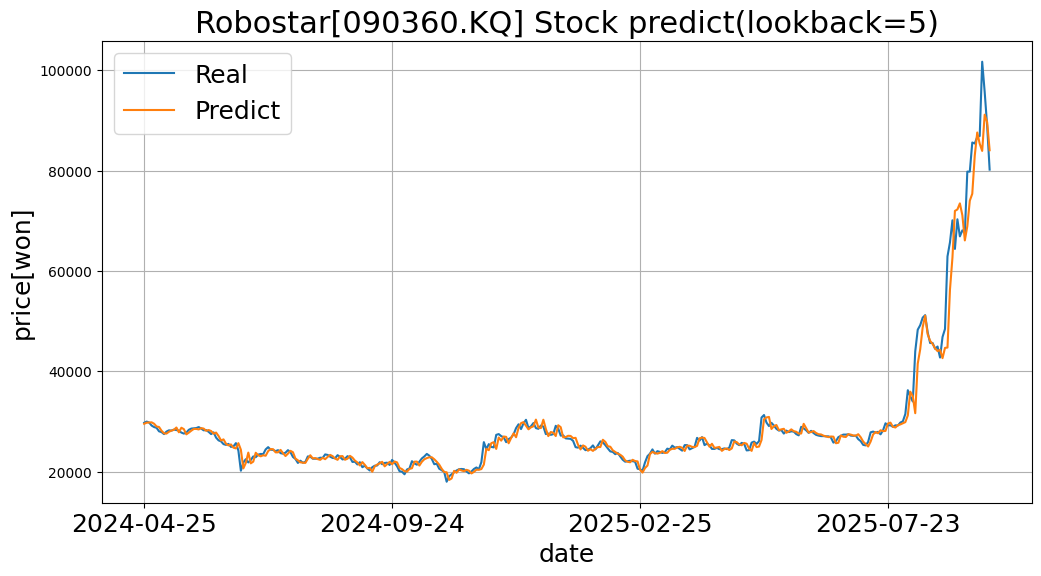

In [80]:
from matplotlib import figure
x_test=[]

for idx in range(test_data.shape[0] - lookback):
  x_test.append(test_data[idx:idx+lookback])
x_test = np.array(x_test)

model = keras.models.load_model("best_model.h5")
y_pred_norm = model.predict(x_test[:,:])  # 예측 결과 (정규화된 값)

num_features = data.shape[1]
dummy = np.zeros((y_pred_norm.shape[0], num_features))
dummy[:, :y_pred_norm.shape[1]] = y_pred_norm
y_pred_full = scaler.inverse_transform(dummy)
y_pred = y_pred_full[:, :y_pred_norm.shape[1]]

figure=plt.figure(figsize=(12,6))
plt.plot(data[train_idx+lookback:,close_idx])
plt.plot(y_pred[:,close_idx])
plt.title("Robostar[090360.KQ] Stock predict(lookback="+str(lookback)+")",fontsize=22)
plt.legend(["Real","Predict"],fontsize=18)

plt.ylabel("price[won]",fontsize=18)
plt.xlabel("date",fontsize=18)
plt.grid(visible=True)
plt.xticks(
    [0, 100, 200, 300],
    [
        date_short[train_idx + lookback],
        date_short[train_idx + lookback + 100],
        date_short[train_idx + lookback + 200],
        date_short[train_idx + lookback + 300]
    ],
    fontsize=18
)

plt.show()


In [81]:
x_test.shape

(342, 5, 10)